In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Read prepared B data for track-based and vertex-based tagging

In [2]:
import pandas
Bdata_tracks = pandas.read_csv('models/Bdata_tracks_PID_less_normed.csv')
Bdata_vertex = pandas.read_csv('models/Bdata_vertex.csv')

In [3]:
Bdata_tracks.head()

,Bsign,Bweight,event_id,track_relation_prob
0,1,1.091776,111761_12239990,0.667845
1,1,-0.237732,111761_14379738,0.950112
2,1,-0.417194,111761_16432326,1.524165
3,-1,1.044602,111761_29035939,1.557460
4,-1,1.062837,111761_30938577,0.686861


In [4]:
Bdata_vertex.head()

,Bsign,Bweight,event_id,vertex_relation_prob
0,1,1.091776,111761_12239990,1.410856
1,1,-0.237732,111761_14379738,0.360223
2,1,-0.442830,111761_33866816,1.278433
3,-1,0.991477,111761_43041334,0.928330
4,-1,1.091055,111761_48273537,0.821604


### Merge two datasets

In [5]:
Bdata = pandas.merge(Bdata_tracks, Bdata_vertex, how='outer', on=['event_id', 'Bsign'])

In [6]:
Bdata.head()

,Bsign,Bweight_x,event_id,track_relation_prob,Bweight_y,vertex_relation_prob
0,1,1.091776,111761_12239990,0.667845,1.091776,1.410856
1,1,-0.237732,111761_14379738,0.950112,-0.237732,0.360223
2,1,-0.417194,111761_16432326,1.524165,NaN,NaN
3,-1,1.044602,111761_29035939,1.557460,NaN,NaN
4,-1,1.062837,111761_30938577,0.686861,NaN,NaN


### Obtain one weight column

In [7]:
Bdata['Bweight'] = Bdata['Bweight_x'].copy()
Bdata.ix[numpy.isnan(Bdata['Bweight'].values), 'Bweight'] = Bdata.ix[numpy.isnan(Bdata['Bweight'].values), 'Bweight_y']
Bdata = Bdata.drop(['Bweight_x', 'Bweight_y'], axis=1)

# for Nan put 1 as non influence factor
Bdata.ix[numpy.isnan(Bdata.track_relation_prob.values), 'track_relation_prob'] = 1.
Bdata.ix[numpy.isnan(Bdata.vertex_relation_prob.values), 'vertex_relation_prob'] = 1.

In [8]:
Bdata.head()

,Bsign,event_id,track_relation_prob,vertex_relation_prob,Bweight
0,1,111761_12239990,0.667845,1.410856,1.091776
1,1,111761_14379738,0.950112,0.360223,-0.237732
2,1,111761_16432326,1.524165,1.000000,-0.417194
3,-1,111761_29035939,1.557460,1.000000,1.044602
4,-1,111761_30938577,0.686861,1.000000,1.062837


In [9]:
relation_prob = Bdata['track_relation_prob'].values * Bdata['vertex_relation_prob'].values
Bprob = relation_prob / (1 + relation_prob)
Bweight = Bdata.Bweight.values
Bsign = Bdata.Bsign.values

In [10]:
Bprob[~numpy.isfinite(Bprob)] = 0.5

## 2-folding calibration by isotonic

In [11]:
from utils import calibrate_probs
Bprob_calibrated, (iso_reg1, iso_reg2) = calibrate_probs(Bsign, Bweight, Bprob,
                                                         symmetrize=True, return_calibrator=True)

#### Add some small noise in prediction for stability

In [12]:
Bprob_calibrated = Bprob_calibrated + numpy.random.normal(size=len(Bprob_calibrated)) * 0.001

(<matplotlib.legend.Legend at 0x7f5fc8556650>,
 <matplotlib.text.Text at 0x7f5fc8527e50>)

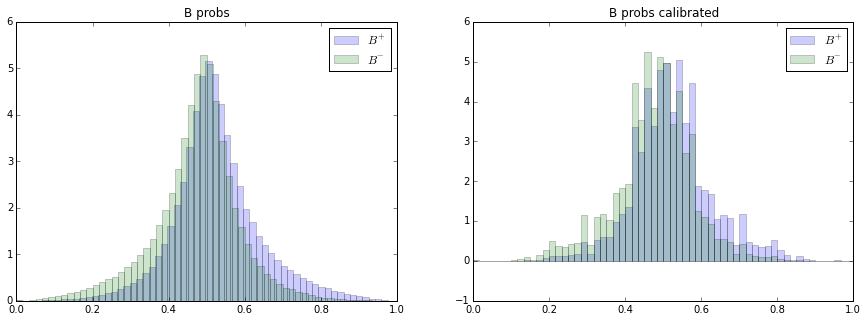

In [13]:
figure(figsize=(15, 5))

subplot(1,2,1)
hist(Bprob[Bsign == 1], weights=Bweight[Bsign == 1], bins=60, alpha=0.2, normed=True, label='$B^+$')
hist(Bprob[Bsign == -1], weights=Bweight[Bsign == -1], bins=60, alpha=0.2, normed=True, label='$B^-$')
legend(), title('B probs')

subplot(1,2,2)
hist(Bprob_calibrated[Bsign == 1], weights=Bweight[Bsign == 1], bins=60, alpha=0.2, 
     normed=True, range=(0, 1), label='$B^+$')
hist(Bprob_calibrated[Bsign == -1], weights=Bweight[Bsign == -1], bins=60, alpha=0.2,
     normed=True, range=(0, 1), label='$B^-$')
legend(), title('B probs calibrated')
# plt.savefig('img/Bprob_iso_calibrated_PID_less.png' , format='png')

## AUC score and ROC curve for B+ vs B-

In [14]:
figsize(12, 10)

AUC for tagged: 0.621524715596 AUC with untag: 0.621513837353


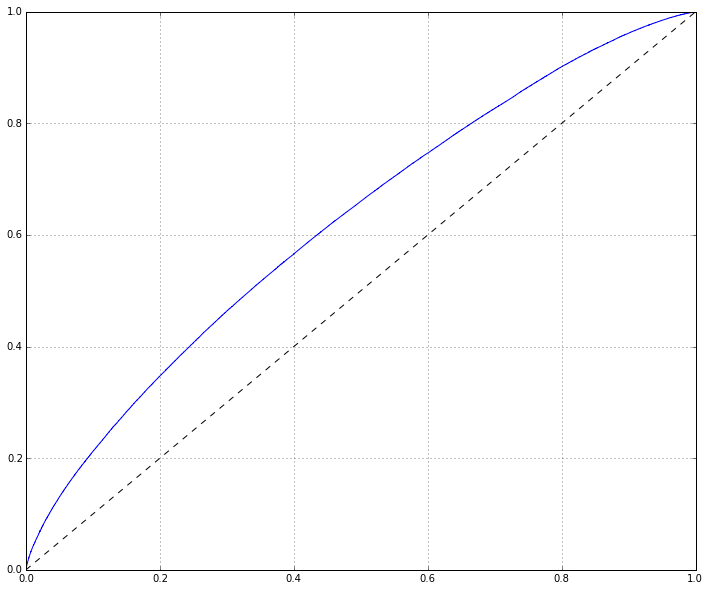

In [15]:
from utils import calculate_auc_with_and_without_untag_events
from sklearn.metrics import roc_curve

auc, auc_full = calculate_auc_with_and_without_untag_events(Bsign, Bprob_calibrated, Bweight)
print 'AUC for tagged:', auc, 'AUC with untag:', auc_full

fpr, tpr, _ = roc_curve(Bsign, Bprob_calibrated, sample_weight=Bweight)
plot(fpr, tpr)
plot([0, 1], [0, 1], 'k--')
ylim(0, 1), xlim(0, 1)
grid()

## Symmetry $B^+$ vs $B^-$ checking

### before calibration

(<matplotlib.legend.Legend at 0x7f5fc888d210>,
 <matplotlib.text.Text at 0x7f5fc303fed0>)

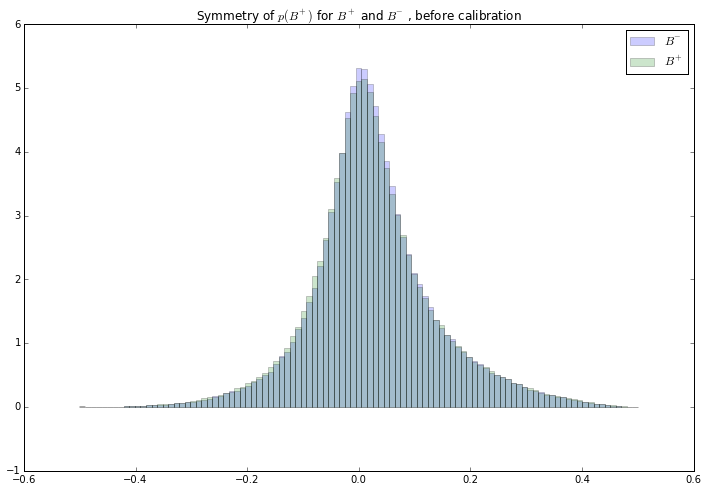

In [16]:
figsize(12, 8)
for sign in [-1, 1]:
    hist(sign * (Bprob[Bsign == sign] - 0.5), bins=101, normed=True, alpha=0.2, 
         weights=Bweight[Bsign == sign], range=(-0.5, 0.5), label='$B^-$' if sign == -1 else '$B^+$')
legend(), title('Symmetry of $p(B^+)$ for $B^+$ and $B^-$, before calibration')

#### KS distance

In [17]:
fpr, tpr, _ = roc_curve(Bsign, (Bprob - 0.5) * Bsign, sample_weight=Bweight)

In [18]:
'KS distance', max(abs(fpr - tpr))

('KS distance', 0.012006704388078049)

((0, 1), (0, 1))

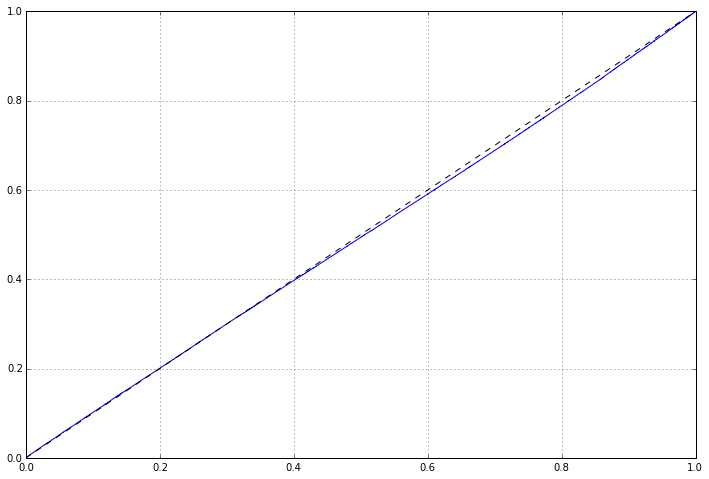

In [19]:
plot(fpr, tpr), grid()
plot([0, 1], [0, 1], 'k--')
xlim(0, 1), ylim(0, 1)


In [20]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Bsign, (Bprob - 0.5) * Bsign, sample_weight=Bweight)

0.49538610949240625

### after calibration

(<matplotlib.legend.Legend at 0x7f5fc888dc50>,
 <matplotlib.text.Text at 0x7f5fc827c890>)

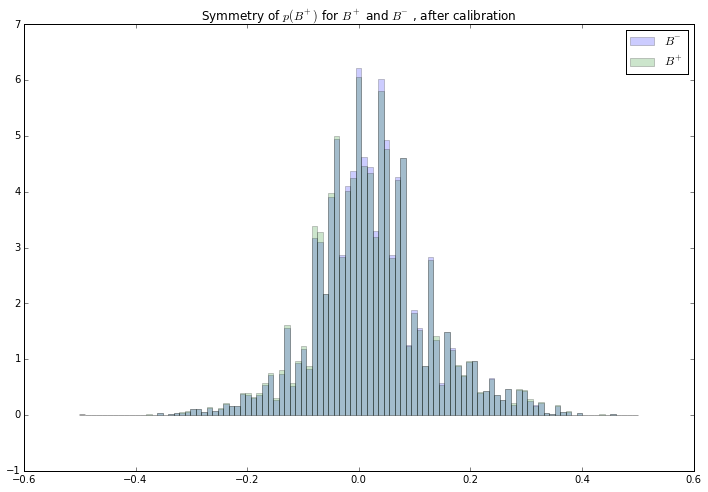

In [21]:
figsize(12, 8)
for sign in [-1, 1]:
    hist(sign * (Bprob_calibrated[Bsign == sign] - 0.5), bins=101, normed=True, alpha=0.2,
         weights=Bweight[Bsign == sign], range=(-0.5, 0.5), label='$B^-$' if sign == -1 else '$B^+$')
legend(), title('Symmetry of $p(B^+)$ for $B^+$ and $B^-$, after calibration')

#### KS distance

In [22]:
fpr, tpr, _ = roc_curve(Bsign, (Bprob_calibrated - 0.5) * Bsign, sample_weight=Bweight)

In [23]:
'KS distance', max(abs(fpr - tpr))

('KS distance', 0.012043995125201712)

((0, 1), (0, 1))

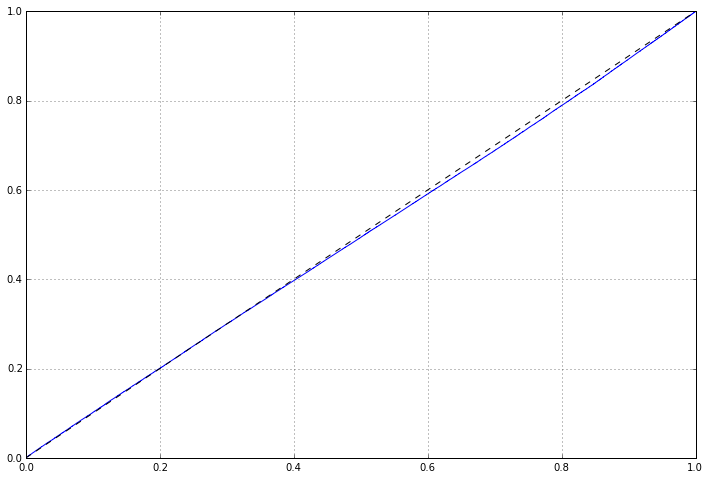

In [24]:
plot(fpr, tpr), grid()
plot([0, 1], [0, 1], 'k--')
xlim(0, 1), ylim(0, 1)

In [25]:
roc_auc_score(Bsign, (Bprob_calibrated - 0.5) * Bsign, sample_weight=Bweight)

0.49542098569358439

## D2 estimation with bootstrap calibration

In [26]:
from utils import get_N_B_events, bootstrap_calibrate_prob, result_table

N_B_passed = Bweight.sum()
tagging_efficiency = N_B_passed / get_N_B_events()
tagging_efficiency_delta = numpy.sqrt(N_B_passed) / get_N_B_events()
print numpy.average((2*(Bprob - 0.5))**2, weights=Bweight) * tagging_efficiency * 100
print numpy.average((2*(Bprob_calibrated - 0.5))**2, weights=Bweight) * Bweight.sum() / get_N_B_events() * 100 

5.37972641931
4.47706246878


In [36]:
D2, aucs = bootstrap_calibrate_prob(Bsign, Bweight, Bprob, symmetrize=True)
print 'AUC', numpy.mean(aucs), numpy.var(aucs)

result = result_table(tagging_efficiency, tagging_efficiency_delta, D2, auc_full, 'Inclusive tagging, PID less')

AUC 0.641087305491 4.50068063076e-07


In [37]:
result

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,"Inclusive tagging, PID less",99.985947,0.116015,0.058732,0.000431,5.872386,0.043591,64.088992,0


In [38]:
result.to_csv('img/new-tagging-PID-less.csv', header=True, index=False)

## Some plots

### Isotonic transformation, and its reverse (too check symmetry)

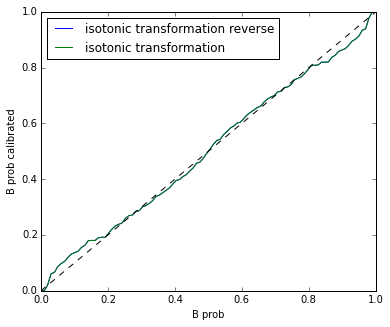

In [29]:
x = numpy.linspace(0, 1, 100)
plot(x, -(iso_reg1.transform((1-x)) + iso_reg2.transform((1-x))) / 2 + 1, label='isotonic transformation reverse')
plot(x, (iso_reg1.transform(x) + iso_reg2.transform(x)) / 2, label='isotonic transformation')
legend(loc='best')
plot([0, 1], [0, 1], "k--")
xlabel('B prob'), ylabel('B prob calibrated')
plt.savefig('img/iso_transformation_PID_less.png' , format='png')

### Mistag checking

In [14]:
from utils import get_N_B_events, compute_mistag

In [15]:
bins = [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
percentile_bins = [10, 20, 30, 40, 50, 60, 70, 80, 90]

### before calibration

/moosefs/ipython_env/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


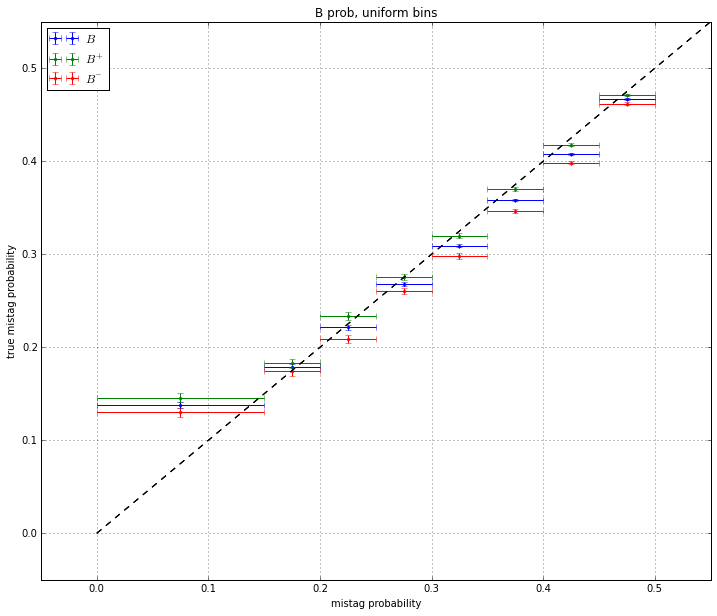

In [32]:
figsize(12, 10)
compute_mistag(Bprob, Bsign, Bweight, Bsign > -100, label="$B$", bins=bins)
compute_mistag(Bprob, Bsign, Bweight, Bsign == 1, label="$B^+$", bins=bins)
compute_mistag(Bprob, Bsign, Bweight, Bsign == -1, label="$B^-$", bins=bins)
legend(loc='best')
title('B prob, uniform bins'), xlabel('mistag probability'), ylabel('true mistag probability')
plt.savefig('img/Bprob_calibration_check_uniform_PID_less.png' , format='png')

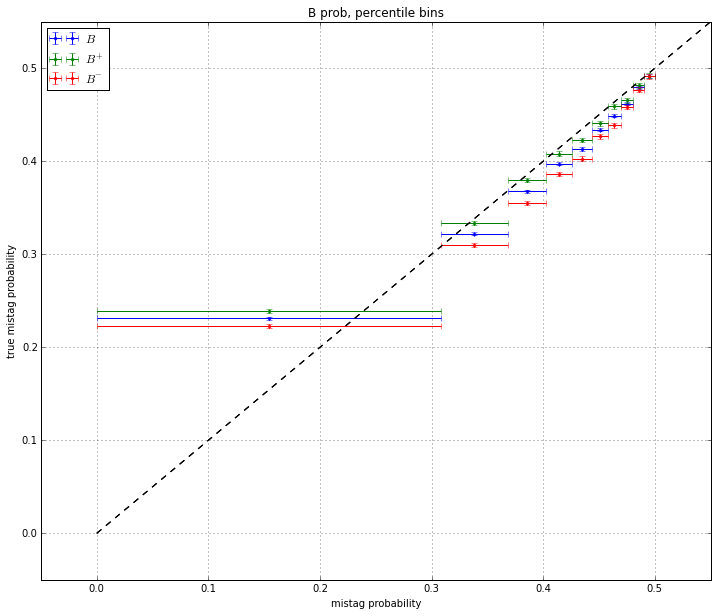

In [33]:
compute_mistag(Bprob, Bsign, Bweight, Bsign > -100, label="$B$", uniform=False, bins=percentile_bins)
p1 = compute_mistag(Bprob, Bsign, Bweight, Bsign == 1, label="$B^+$", uniform=False, bins=percentile_bins)
compute_mistag(Bprob, Bsign, Bweight, Bsign == -1, label="$B^-$", uniform=False, bins=percentile_bins)
legend(loc='best')
title('B prob, percentile bins'), xlabel('mistag probability'), ylabel('true mistag probability')
plt.savefig('img/Bprob_calibration_check_percentile_PID_less.png' , format='png')

### after calibration

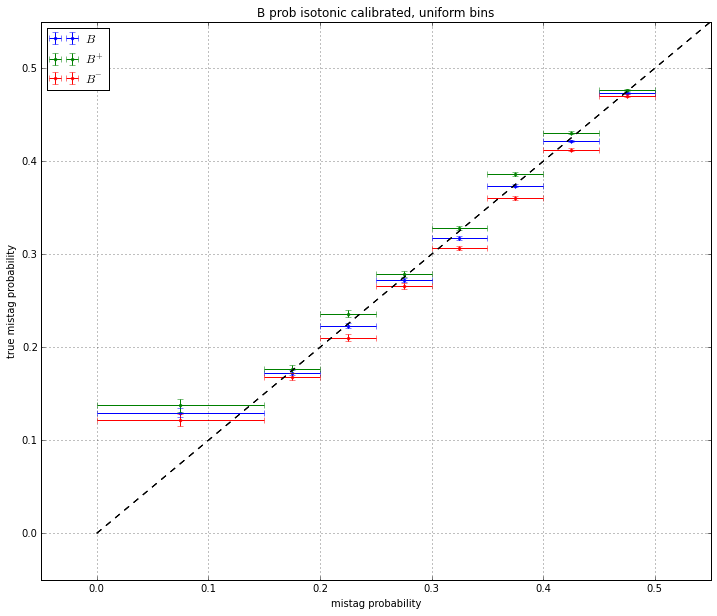

In [34]:
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign > -100, label="$B$", bins=bins)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign == 1, label="$B^+$", bins=bins)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign == -1, label="$B^-$", bins=bins)
legend(loc='best')
title('B prob isotonic calibrated, uniform bins'), xlabel('mistag probability'), ylabel('true mistag probability')
plt.savefig('img/Bprob_calibration_check_iso_uniform_PID_less.png' , format='png')

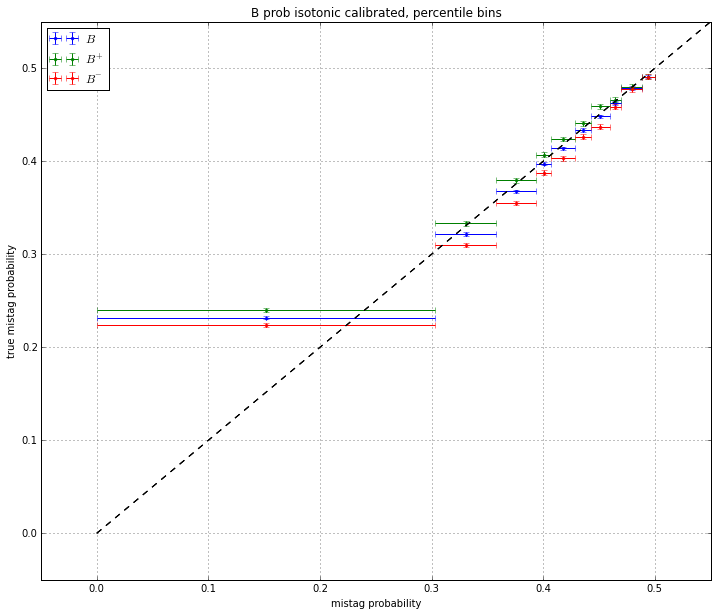

In [35]:
figsize(12, 10)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign > -100, label="$B$", uniform=False,
               bins=percentile_bins)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign == 1, label="$B^+$", uniform=False, 
               bins=percentile_bins)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign == -1, label="$B^-$", uniform=False, 
               bins=percentile_bins)
legend(loc='best'),  xlabel('mistag probability'), ylabel('true mistag probability')
title('B prob isotonic calibrated, percentile bins')
plt.savefig('img/Bprob_calibration_check_iso_percentile_PID_less.png' , format='png')

## Flatness investigation

In [66]:
root_numpy.list_branches('datasets/tracks.root', 'tracks')

['index',
 'run',
 'event',
 'Bmass',
 'i',
 'mult',
 'partP',
 'partPt',
 'ptB',
 'IPs',
 'IP',
 'IPerr',
 'partlcs',
 'EOverP',
 'ghostProb',
 'IPPU',
 'nnkrec',
 'PIDNNk',
 'PIDNNpi',
 'PIDNNp',
 'PIDNNm',
 'PIDNNe',
 'diff_eta',
 'diff_phi',
 'phi',
 'eta',
 'proj',
 'ID',
 'veloch',
 'signB',
 'signTrack',
 'Dist_phi',
 'N_sig_sw',
 'mu_cut',
 'e_cut',
 'K_cut']

In [67]:
import root_numpy
data_full = pandas.DataFrame(root_numpy.root2array('datasets/tracks.root', 'tracks', 
                                                   branches=['run', 'event', 'Bmass', 'ptB', 'ghostProb']))

In [ ]:
# root_numpy.list_branches('datasets/BuJpsiK_2011and2012_3gaussMass.root', 'DecayTree') , ['tagdecision_os_wOSD',
#  'tagomega_os_wOSD',]

In [17]:
data_tau = pandas.DataFrame(root_numpy.root2array('datasets/BuJpsiK_2011and2012_3gaussMass.root', 'DecayTree', 
                                                  branches=['runNumber', 'eventNumber', 'time', 'sigmat', 'B_P', 
                                                            'B_Pt', 'nTracks']))

In [69]:
event_id_column = 'event_id'
event_id = data_full.run.apply(str) + '_' + data_full.event.apply(str)
data_full = data_full.ix[numpy.unique(event_id, return_index=True)[1], :]

In [70]:
data_full.index = numpy.unique(event_id)

In [21]:
event_id = data_tau.runNumber.apply(str) + '_' + data_tau.eventNumber.apply(str)
data_tau = data_tau.ix[numpy.unique(event_id, return_index=True)[1], :]

In [22]:
data_tau.index = numpy.unique(event_id)

In [23]:
Bmass = data_full.ix[Bdata.event_id, 'Bmass'].values
Bpt = data_full.ix[Bdata.event_id, 'ptB'].values

In [26]:
tau = data_tau.ix[Bdata.event_id, 'time'].values
Bp = data_tau.ix[Bdata.event_id, 'B_P'].values
tau_error = data_tau.ix[Bdata.event_id, 'sigmat'].values
ntracks = data_tau.ix[Bdata.event_id, 'nTracks'].values
Bpt_mirco = data_tau.ix[Bdata.event_id, 'B_Pt'].values / 1000.

In [50]:
set(Bdata.event_id).issubset(set(data_tau.index))

False

In [52]:
x = numpy.in1d(Bdata.event_id, data_tau.index)

In [85]:
mask = ~numpy.isnan(Bpt_mirco)

In [86]:
from rep.utils import weighted_quantile

In [87]:
def compute_flatness(Bprob, Bsign, Bweight, mask, spectator, bins, label="", uniform=True):
    bins_flat = weighted_quantile(spectator, [0, 0.2, 0.4, 0.6, 0.8, 1], sample_weight=Bweight)
    for i, (left, right) in enumerate(zip(bins_flat[:-1], bins_flat[1:])):
        bin_mask = (spectator >= left) * (spectator < right)
        compute_mistag(Bprob, Bsign, Bweight, mask*bin_mask, label=label+" bin %d"% i, uniform=uniform,
                       bins=bins)
    legend(loc='best')

In [88]:
from hep_ml.metrics import BinBasedCvM

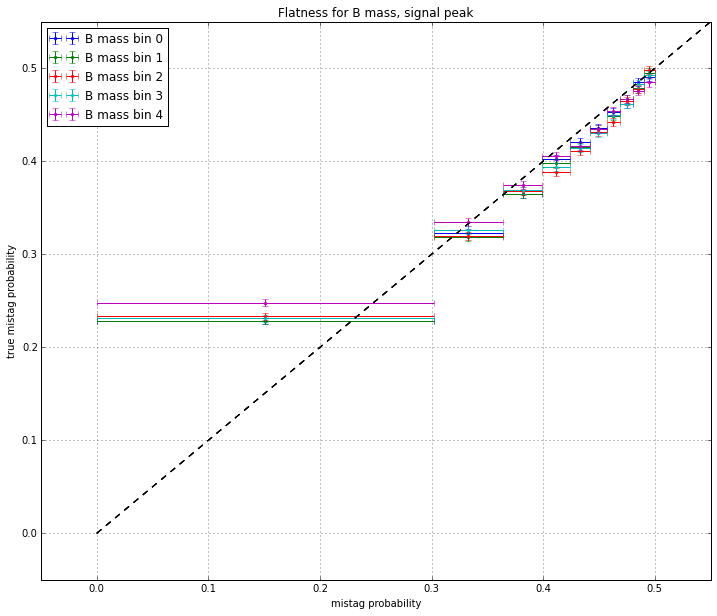

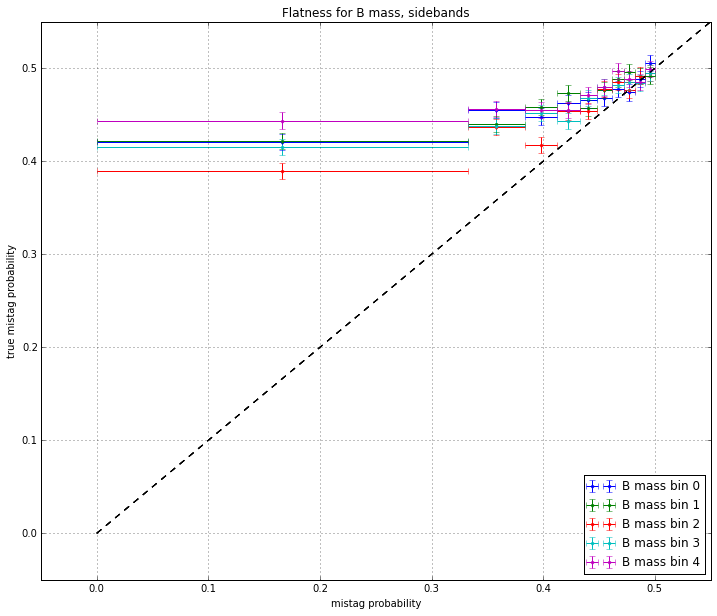

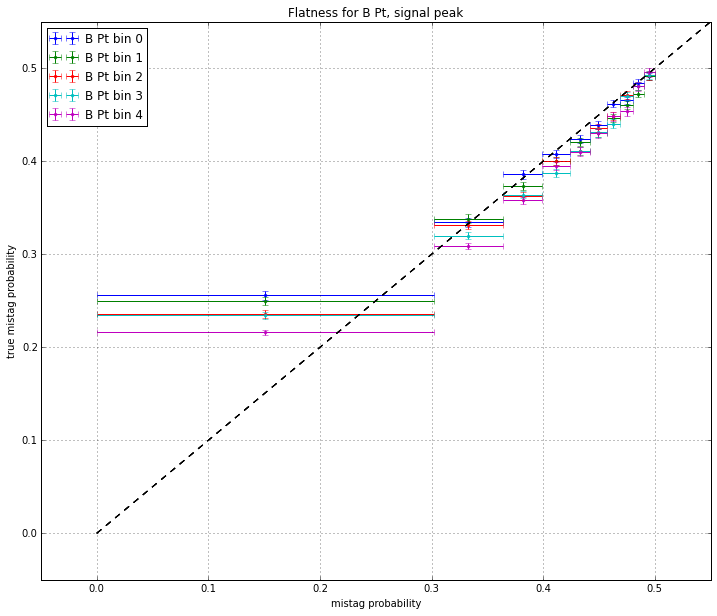

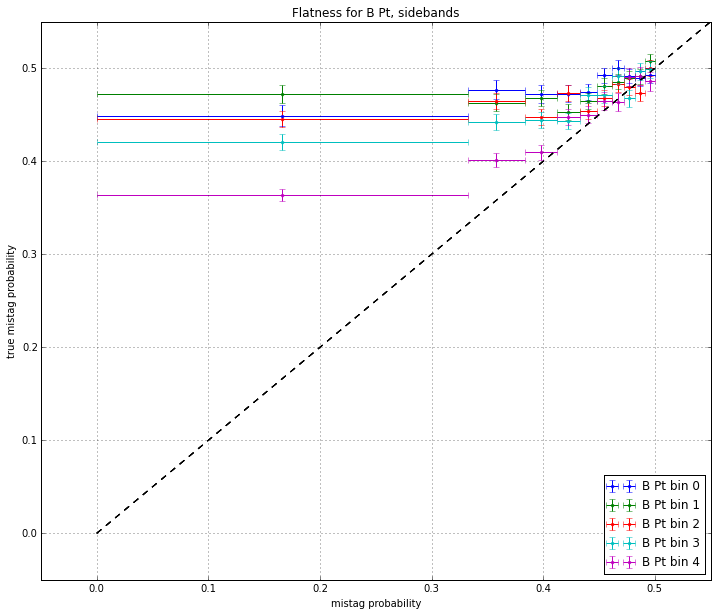

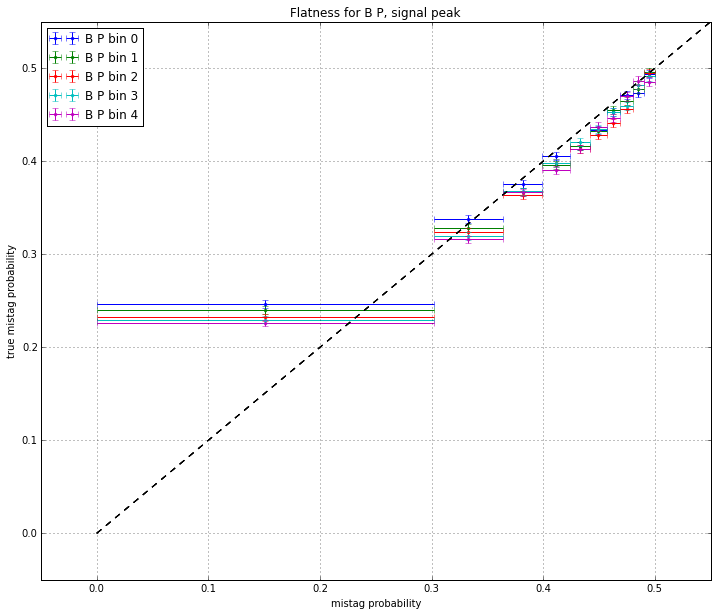

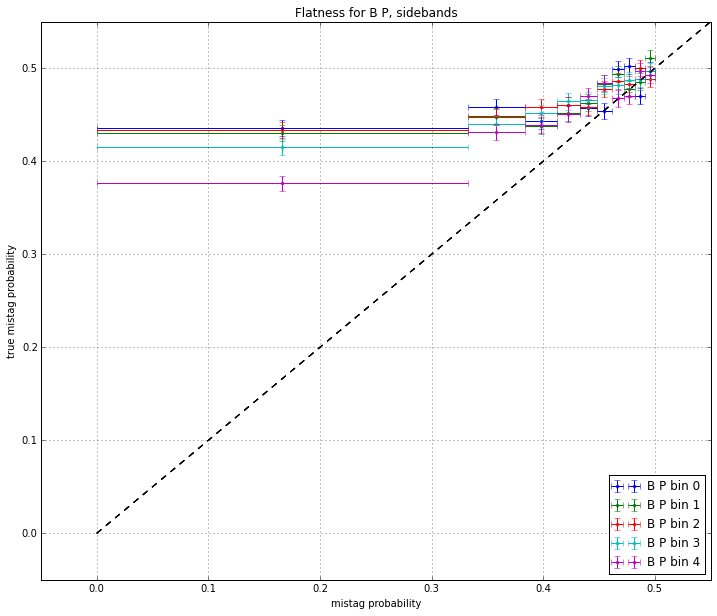

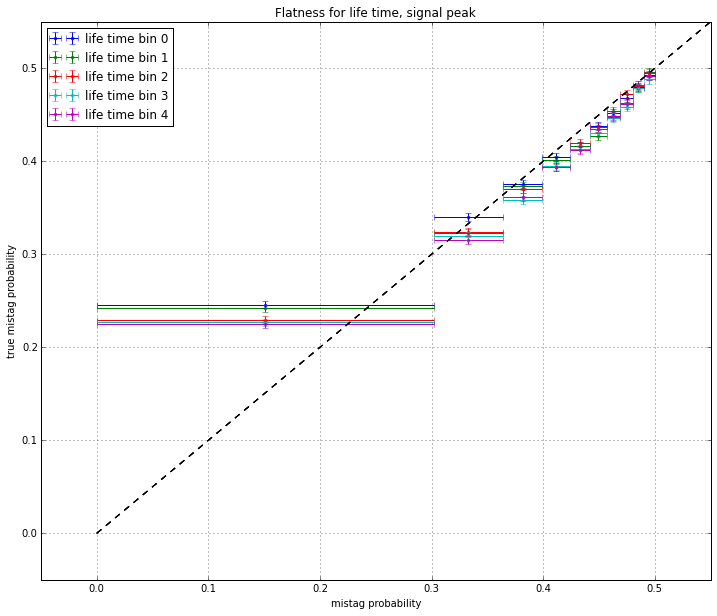

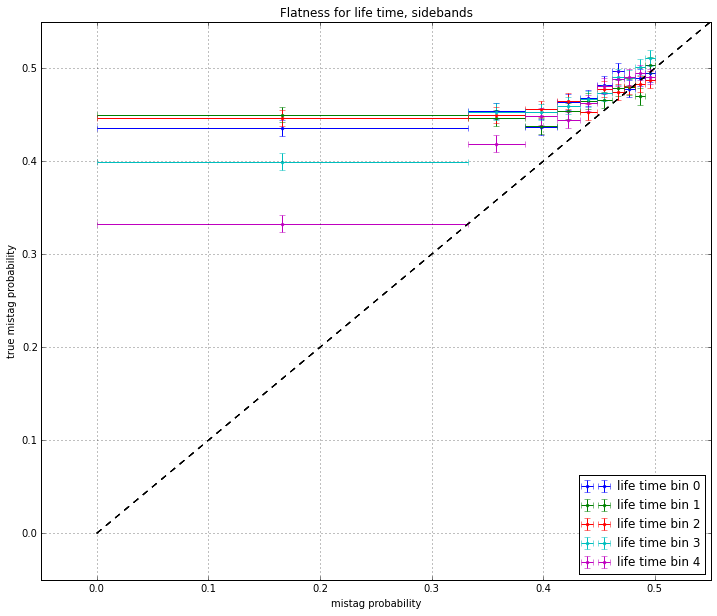

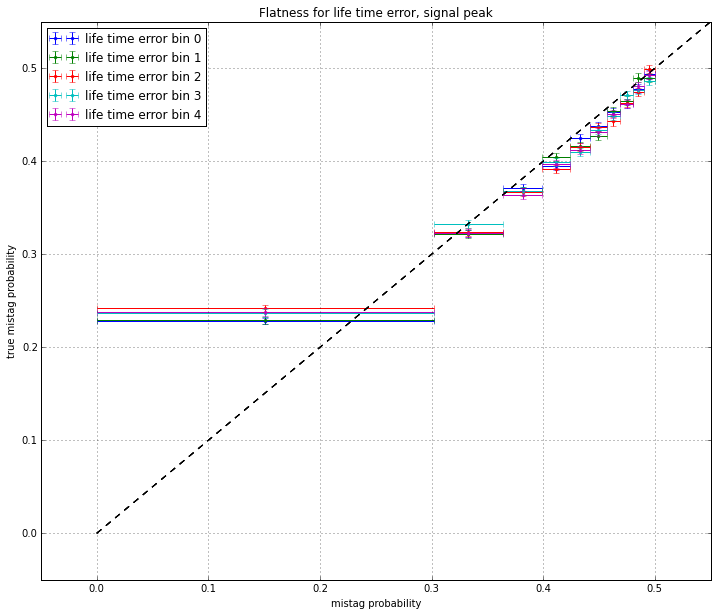

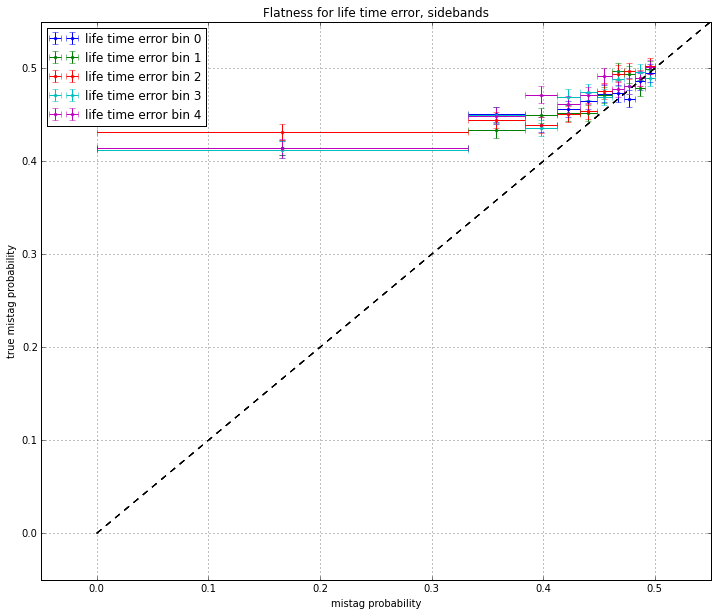

In [100]:
figsize(12, 10)
mask_signal = ((Bmass > 5.27) & (Bmass < 5.3)) & mask
mask_bck = ((Bmass < 5.25) | (Bmass > 5.32)) * mask
for flatness_feature, flatness_name in zip([Bmass, Bpt, Bp, tau, tau_error], 
                                           ['B mass', 'B Pt', 'B P', 'life time', 'life time error']):
    compute_flatness(Bprob[mask_signal], Bsign[mask_signal], Bweight[mask_signal] * 0 + 1, 
                     (Bsign[mask_signal] > -100), flatness_feature[mask_signal],
                     percentile_bins, label=flatness_name, uniform=False)
    legend(loc='best'),  xlabel('mistag probability'), ylabel('true mistag probability')
    title('Flatness for %s, signal peak' %flatness_name)
    show()
    
    compute_flatness(Bprob[mask_bck], Bsign[mask_bck], Bweight[mask_bck] * 0 + 1, 
                     (Bsign[mask_bck] > -100), flatness_feature[mask_bck],
                     percentile_bins, label=flatness_name, uniform=False)
    legend(loc='best'),  xlabel('mistag probability'), ylabel('true mistag probability')
    title('Flatness for %s, sidebands' %flatness_name)
    show()

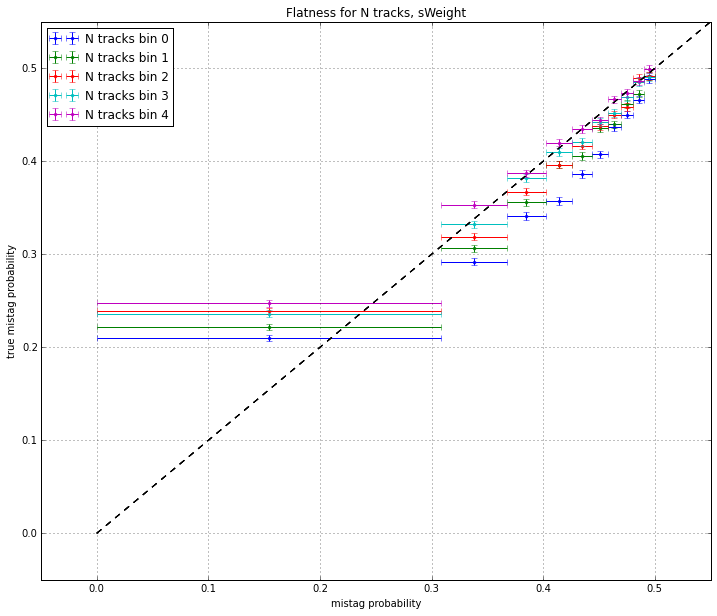

In [104]:
figsize(12, 10)
mask_signal = mask
compute_flatness(Bprob[mask], Bsign[mask], Bweight[mask], 
                 (Bsign[mask] > -100), ntracks[mask],
                 percentile_bins, label="N tracks", uniform=False)
legend(loc='best'),  xlabel('mistag probability'), ylabel('true mistag probability')
title('Flatness for N tracks, sWeight')

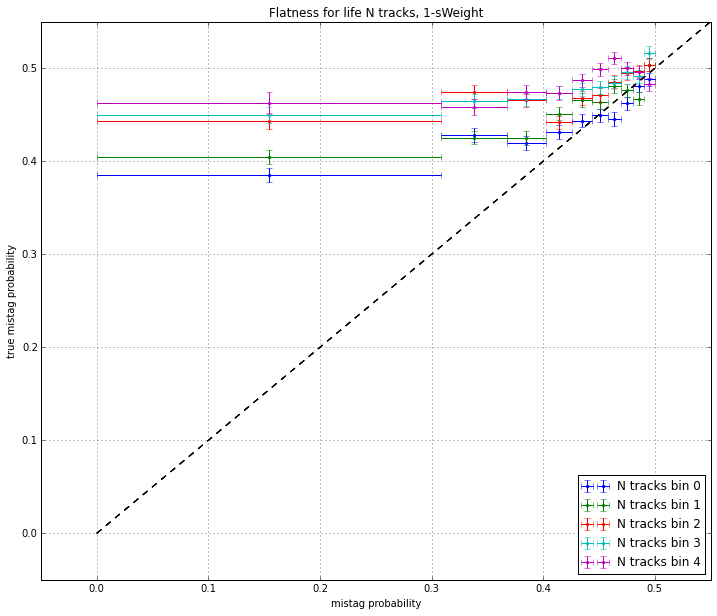

In [103]:
figsize(12, 10)
mask_signal =  mask
compute_flatness(Bprob[mask], Bsign[mask], 1 - Bweight[mask],  
                 (Bsign[mask] > -100), ntracks[mask],
                 percentile_bins, label="N tracks", uniform=False)
legend(loc='best'),  xlabel('mistag probability'), ylabel('true mistag probability')
title('Flatness for life N tracks, 1-sWeight')

In [ ]:
pandas.read_csv('datasets/Tracks.csv', nrows=10, sep='\t').columns

In [130]:
a = root_numpy.root2array('datasets/1016_vtx.root', branches=['mult'])['mult']
b = root_numpy.root2array('datasets/1016_vtx.root', branches=['vflag'])['vflag']
c = root_numpy.root2array('datasets/1016_vtx.root', branches=['N_sig_sw'])['N_sig_sw']

In [131]:
sum(b * 1. / a  * c)  / sum(c)

0.1158256213875837

In [ ]:
data_full = pandas.DataFrame(root_numpy.root2array('datasets/tracks.root', 'tracks', 
                                                   branches=['run', 'event', 'Bmass', 'ptB', 'ghostProb']))